**IC888日内趋势策略**

1. 读取、整理数据。
2. 计算信号
3. 统计策略收益及表现。
4. 参数调优。
5. 策略推荐。

策略：
 - 1.当 m分钟均价 > 当日开盘价 + k*range 后: 持有1单位
 - 2.当 m分钟均价 < 当日开盘价 - k*range 后：持有-1单位
 - 若1发生后2发生 或 2发生后1发生 则按照后发生的情况进行调仓
 - 其他情况：保持原有持仓不变，以收盘价清仓。

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

1.读取、整理数据。
 - 读取数据：（2016年1月4日至今）

In [2]:
rawdata = pd.read_csv('2016IC888.csv')
rawdata

,time,open,high,low,close,volume,oi,day
0,930,7350.0,7358.6,7321.2,7340.8,185,14179,20160104
1,931,7340.8,7345.6,7334.8,7345.2,60,14150,20160104
2,932,7344.4,7347.6,7337.4,7346.2,33,14134,20160104
3,933,7346.6,7349.4,7338.0,7338.0,66,14108,20160104
4,934,7344.0,7364.8,7338.2,7358.8,68,14067,20160104
...,...,...,...,...,...,...,...,...
267399,1455,6682.8,6683.8,6672.6,6677.6,696,92624,20200803
267400,1456,6677.2,6677.2,6671.2,6675.2,638,92805,20200803
267401,1457,6675.0,6675.0,6669.6,6671.0,770,93164,20200803
267402,1458,6670.8,6673.4,6669.8,6672.2,631,93474,20200803


 - 整理数据：
   - 将每日每分钟开盘价进行排序，一天为一列：

In [3]:
#交易日排列
date_set = set(rawdata['day'])
date_list = list(date_set)
date_list.sort()

#按交易日构建新数据表格
newdata = pd.DataFrame(index = date_list)
newdata.index.name = 'Trade day'
close_table = pd.DataFrame(index = date_list)
close_table.index.name = 'Trade day'

row_num = rawdata.shape[0]

#以每分钟开盘价作为参考
data_open = rawdata['open']
data_close = rawdata['close']
price_time = rawdata['day']

for i in range(row_num):
    if i == 0:
        col_index = 0
        row_index = 0
        newdata.at[date_list[row_index], col_index] = data_open[i]
        close_table.at[date_list[row_index], col_index] = data_close[i]
    elif price_time[i] == price_time[i-1]:
        col_index = col_index + 1
        newdata.at[date_list[row_index], col_index] = data_open[i]
        close_table.at[date_list[row_index], col_index] = data_close[i]
    else:
        col_index = 0
        row_index = row_index+1
        newdata.at[date_list[row_index], col_index] = data_open[i]
        close_table.at[date_list[row_index], col_index] = data_close[i]

newdata

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
Trade day,,,,,,,,,,,,,,,,,,,,,
20160104,7350.0,7340.8,7344.4,7346.6,7344.0,7359.0,7360.4,7356.6,7334.2,7332.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160105,6650.0,6650.0,6670.0,6685.6,6699.2,6723.8,6734.4,6733.0,6730.4,6751.8,...,6679.4,6675.0,6698.0,6697.0,6695.8,6685.4,6685.0,6697.8,NaN,NaN
20160106,6749.0,6767.2,6756.2,6752.0,6761.0,6787.8,6809.2,6794.8,6808.0,6795.0,...,6846.0,6836.4,6835.6,6836.6,6835.0,6824.8,6819.8,6820.0,6819.0,6815.0
20160107,6745.8,6715.4,6718.4,6730.0,6723.4,6679.2,6683.6,6618.6,6525.4,6535.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160108,6520.0,6538.8,6489.6,6499.2,6460.2,6459.0,6407.2,6416.6,6419.8,6426.8,...,6404.0,6402.8,6405.0,6406.0,6417.0,6418.2,6411.0,6408.0,6410.0,6410.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200728,6278.8,6286.4,6291.8,6285.4,6277.8,6300.4,6301.0,6300.4,6296.0,6296.2,...,6260.2,6254.2,6249.0,6255.0,6255.6,6258.2,6254.8,6259.6,6258.0,6251.2
20200729,6229.8,6247.4,6256.6,6255.0,6248.0,6262.0,6265.2,6261.4,6264.0,6257.2,...,6494.0,6496.2,6497.2,6496.0,6490.2,6492.2,6489.8,6494.0,6489.0,6493.6
20200730,6518.0,6521.6,6528.0,6518.2,6511.6,6505.0,6505.2,6512.6,6503.8,6503.4,...,6448.6,6451.0,6453.2,6452.6,6450.6,6457.4,6453.2,6453.0,6454.8,6452.4


- 根据分钟数据计算每日最高价、最低价、收盘价

In [4]:
data_high = rawdata['high']
data_low = rawdata['low']
data_close = rawdata['close']

row_index = 0
count_start = 0
count_end = 1

for i in range(row_num):
    if i == row_num-1:
        newdata.at[date_list[row_index], 'high'] = max(data_high[count_start:count_end])
        newdata.at[date_list[row_index], 'low'] = min(data_low[count_start:count_end])
        newdata.at[date_list[row_index], 'close'] = data_close[i]
    elif price_time[i] == price_time[i+1]:
        count_end = count_end + 1
    else:
        newdata.at[date_list[row_index], 'high'] = max(data_high[count_start:count_end])
        newdata.at[date_list[row_index], 'low'] = min(data_low[count_start:count_end])
        newdata.at[date_list[row_index], 'close'] = data_close[i]
        row_index = row_index + 1
        count_start = count_end
        count_end = count_end + 1

newdata.to_csv('IC888new.csv')
newdata

,0,1,2,3,4,5,6,7,8,9,...,233,234,235,236,237,238,239,high,low,close
Trade day,,,,,,,,,,,,,,,,,,,,,
20160104,7350.0,7340.8,7344.4,7346.6,7344.0,7359.0,7360.4,7356.6,7334.2,7332.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7364.8,6881.2,6881.2
20160105,6650.0,6650.0,6670.0,6685.6,6699.2,6723.8,6734.4,6733.0,6730.4,6751.8,...,6697.0,6695.8,6685.4,6685.0,6697.8,NaN,NaN,6880.0,6650.0,6699.0
20160106,6749.0,6767.2,6756.2,6752.0,6761.0,6787.8,6809.2,6794.8,6808.0,6795.0,...,6836.6,6835.0,6824.8,6819.8,6820.0,6819.0,6815.0,6870.0,6701.0,6814.4
20160107,6745.8,6715.4,6718.4,6730.0,6723.4,6679.2,6683.6,6618.6,6525.4,6535.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6745.8,6360.0,6360.0
20160108,6520.0,6538.8,6489.6,6499.2,6460.2,6459.0,6407.2,6416.6,6419.8,6426.8,...,6406.0,6417.0,6418.2,6411.0,6408.0,6410.0,6410.0,6588.8,6150.0,6399.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200728,6278.8,6286.4,6291.8,6285.4,6277.8,6300.4,6301.0,6300.4,6296.0,6296.2,...,6255.0,6255.6,6258.2,6254.8,6259.6,6258.0,6251.2,6328.4,6200.4,6252.0
20200729,6229.8,6247.4,6256.6,6255.0,6248.0,6262.0,6265.2,6261.4,6264.0,6257.2,...,6496.0,6490.2,6492.2,6489.8,6494.0,6489.0,6493.6,6507.0,6228.4,6501.4
20200730,6518.0,6521.6,6528.0,6518.2,6511.6,6505.0,6505.2,6512.6,6503.8,6503.4,...,6452.6,6450.6,6457.4,6453.2,6453.0,6454.8,6452.4,6535.8,6423.0,6453.0


- 数据长度分析：
    - 将1116个交易日的数据长度进行排列。每个数据长度减3即可得到分钟数据长度。
    - 2016年开始交易时长变为240分钟。其中1086个交易日数据为240分钟，1个交易日数据为132分钟（2016年1月4日A股熔断），1个交易日数据为15分钟（2016年1月7日A股熔断），1个交易日数据为183分钟（2020年2月3日）。28个交易日数据分别为239（18次）,238（4次）,237（2次）,236（2次），234（1次）分钟,原因不详。

In [5]:
from collections import Counter
len_list = list(newdata.count(axis='columns'))
Counter(len_list)

Counter({135: 1,
         241: 4,
         243: 1086,
         18: 1,
         242: 18,
         237: 1,
         240: 2,
         239: 2,
         186: 1})

- 剔除数据长度为183的数据（2020年2月3日）：

In [6]:
#每分钟开盘价（计算信号）
newdata = newdata.drop([20200203])
#每分钟收盘价（计算收益）
close_table = close_table.drop([20200203])
date_list.remove(20200203)
newdata

,0,1,2,3,4,5,6,7,8,9,...,233,234,235,236,237,238,239,high,low,close
Trade day,,,,,,,,,,,,,,,,,,,,,
20160104,7350.0,7340.8,7344.4,7346.6,7344.0,7359.0,7360.4,7356.6,7334.2,7332.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7364.8,6881.2,6881.2
20160105,6650.0,6650.0,6670.0,6685.6,6699.2,6723.8,6734.4,6733.0,6730.4,6751.8,...,6697.0,6695.8,6685.4,6685.0,6697.8,NaN,NaN,6880.0,6650.0,6699.0
20160106,6749.0,6767.2,6756.2,6752.0,6761.0,6787.8,6809.2,6794.8,6808.0,6795.0,...,6836.6,6835.0,6824.8,6819.8,6820.0,6819.0,6815.0,6870.0,6701.0,6814.4
20160107,6745.8,6715.4,6718.4,6730.0,6723.4,6679.2,6683.6,6618.6,6525.4,6535.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6745.8,6360.0,6360.0
20160108,6520.0,6538.8,6489.6,6499.2,6460.2,6459.0,6407.2,6416.6,6419.8,6426.8,...,6406.0,6417.0,6418.2,6411.0,6408.0,6410.0,6410.0,6588.8,6150.0,6399.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200728,6278.8,6286.4,6291.8,6285.4,6277.8,6300.4,6301.0,6300.4,6296.0,6296.2,...,6255.0,6255.6,6258.2,6254.8,6259.6,6258.0,6251.2,6328.4,6200.4,6252.0
20200729,6229.8,6247.4,6256.6,6255.0,6248.0,6262.0,6265.2,6261.4,6264.0,6257.2,...,6496.0,6490.2,6492.2,6489.8,6494.0,6489.0,6493.6,6507.0,6228.4,6501.4
20200730,6518.0,6521.6,6528.0,6518.2,6511.6,6505.0,6505.2,6512.6,6503.8,6503.4,...,6452.6,6450.6,6457.4,6453.2,6453.0,6454.8,6452.4,6535.8,6423.0,6453.0


2. 计算信号、持仓、策略收益等：

In [7]:
#可调整参数:
day = 30
minute = 10
SD = 0.1
transcost = 0.0002 

#Range
newdata['HH-LC'] = newdata['high'].rolling(day).max() - newdata['close'].rolling(day).min()
newdata['HC-LL'] = newdata['close'].rolling(day).max() - newdata['low'].rolling(day).min()
newdata['range'] = newdata[['HH-LC', 'HC-LL']].max(axis=1)

#设定天花板和地板
newdata['cap'] = newdata[0] + newdata['range']*SD
newdata['floor'] = newdata[0] - newdata['range']*SD

newdata

,0,1,2,3,4,5,6,7,8,9,...,238,239,high,low,close,HH-LC,HC-LL,range,cap,floor
Trade day,,,,,,,,,,,,,,,,,,,,,
20160104,7350.0,7340.8,7344.4,7346.6,7344.0,7359.0,7360.4,7356.6,7334.2,7332.4,...,NaN,NaN,7364.8,6881.2,6881.2,NaN,NaN,NaN,NaN,NaN
20160105,6650.0,6650.0,6670.0,6685.6,6699.2,6723.8,6734.4,6733.0,6730.4,6751.8,...,NaN,NaN,6880.0,6650.0,6699.0,NaN,NaN,NaN,NaN,NaN
20160106,6749.0,6767.2,6756.2,6752.0,6761.0,6787.8,6809.2,6794.8,6808.0,6795.0,...,6819.0,6815.0,6870.0,6701.0,6814.4,NaN,NaN,NaN,NaN,NaN
20160107,6745.8,6715.4,6718.4,6730.0,6723.4,6679.2,6683.6,6618.6,6525.4,6535.0,...,NaN,NaN,6745.8,6360.0,6360.0,NaN,NaN,NaN,NaN,NaN
20160108,6520.0,6538.8,6489.6,6499.2,6460.2,6459.0,6407.2,6416.6,6419.8,6426.8,...,6410.0,6410.0,6588.8,6150.0,6399.8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200728,6278.8,6286.4,6291.8,6285.4,6277.8,6300.4,6301.0,6300.4,6296.0,6296.2,...,6258.0,6251.2,6328.4,6200.4,6252.0,1352.2,1342.4,1352.2,6414.02,6143.58
20200729,6229.8,6247.4,6256.6,6255.0,6248.0,6262.0,6265.2,6261.4,6264.0,6257.2,...,6489.0,6493.6,6507.0,6228.4,6501.4,1230.4,1290.2,1290.2,6358.82,6100.78
20200730,6518.0,6521.6,6528.0,6518.2,6511.6,6505.0,6505.2,6512.6,6503.8,6503.4,...,6454.8,6452.4,6535.8,6423.0,6453.0,1203.2,1246.6,1246.6,6642.66,6393.34


In [8]:
#信号（m分钟平均价）
ma_price = newdata.rolling(minute, axis=1).mean()  
ma_price.drop(columns = ['high', 'low', 'close', 'HH-LC', 'HC-LL', 'range', 'cap', 'floor'], inplace = True)
ma_price

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
Trade day,,,,,,,,,,,,,,,,,,,,,
20160104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7346.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6702.82,...,6694.58,6691.12,6691.40,6692.10,6691.68,6690.22,6689.16,6689.38,NaN,NaN
20160106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6778.02,...,6838.00,6838.12,6838.38,6837.96,6837.48,6836.12,6835.06,6833.76,6831.72,6828.82
20160107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6667.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6463.72,...,6466.10,6457.58,6448.30,6439.38,6432.70,6426.06,6420.12,6415.48,6412.20,6409.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6291.42,...,6243.20,6246.42,6247.74,6249.86,6251.92,6253.32,6254.04,6255.02,6255.64,6255.58
20200729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6254.66,...,6483.52,6486.94,6489.16,6490.88,6491.82,6492.92,6493.40,6494.04,6493.38,6493.22
20200730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6512.74,...,6456.28,6456.18,6456.02,6455.28,6454.28,6453.72,6453.18,6452.76,6452.68,6452.68


In [9]:
#持仓
position = list()
#holding = 0
for i in range(len(date_list)):
    holding  = 0
    holdings = list()

    cap = newdata.at[date_list[i],'cap']
    floor = newdata.at[date_list[i],'floor']
    
    for j in range(240):
        sig = ma_price.at[date_list[i],j]
        if sig > cap:
            holding = 1
            holdings.append(holding)
        elif sig < floor:
            holding = -1
            holdings.append(holding)
        else:
            holdings.append(holding)
    position.append(holdings)
    
pos = pd.DataFrame(position, index = date_list)
pos.index.name = 'Trade day'
pos[239] = 0 #每天以收盘价清仓
pos

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
Trade day,,,,,,,,,,,,,,,,,,,,,
20160104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20160105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20160106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20160107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20160108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20200729,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
20200730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#策略收益
close0 = close_table.drop(columns = [239])
close1 = close_table.drop(columns = [0])
close1.columns = range(0,239)
pos0 = pos.drop(columns = [239])
pos1 = pos.drop(columns = [0])
pos1.columns = range(0,239)

ret_table = pos0*(np.log(close1)-np.log(close0))
ret_table #每分钟收益（对数）

,0,1,2,3,4,5,6,7,8,9,...,229,230,231,232,233,234,235,236,237,238
Trade day,,,,,,,,,,,,,,,,,,,,,
20160104,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160105,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,NaN,NaN
20160106,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,...,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
20160107,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160108,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,...,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200728,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,...,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
20200729,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,...,0.000277,0.000154,-0.000185,-0.000616,0.000031,-0.000370,0.000678,-0.000832,0.000678,0.001262
20200730,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,...,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000


In [38]:
#收益减去交易成本求和
newdata['ret'] = np.exp(ret_table.sum(axis=1))-1-abs(pos1-pos0).sum(axis=1)*transcost
newdata['ret']

Trade day
20160104    0.000000
20160105    0.000000
20160106    0.000000
20160107    0.000000
20160108    0.000000
              ...   
20200728    0.000000
20200729    0.019172
20200730    0.000000
20200731   -0.011839
20200803    0.000000
Name: ret, Length: 1115, dtype: float64

3.统计策略表现：
  - 策略收益曲线

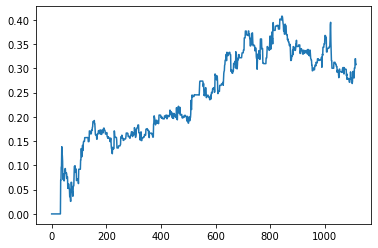

In [39]:
ret = newdata['ret'].cumsum()
plt.plot(ret.values)
plt.show()

 - 统计策略表现

In [13]:
def annual_return(dr):
    return np.sum(dr)*252/(len(dr)-day)

def annual_volatility(dr):
    return dr[day:].std()*252**0.5

def sharpe_ratio(dr):
    try:
        return annual_return(dr)/annual_volatility(dr)
    except ZeroDivisionError:
        return np.nan
    
def max_draw_down(dr):
    return np.nanmax(dr.cumsum().cummax()-dr.cumsum())

def calmar_ratio(dr):
    mdd = max_draw_down(dr)
    if mdd != 0:
        return annual_return(dr)/ max_draw_down(dr)
    else:
        return np.nan

def win_rate(dr):
    win = len([num for num in dr if num>0])
    los = len([num for num in dr if num<0])
    try:
        return win/(win+los)
    except ZeroDivisionError:
        return 0

def performance(dr):  
    performance = pd.Series()
    performance['annual_return'] = annual_return(dr)
    performance['sharpe_ratio'] = sharpe_ratio(dr)
    performance['max_draw_down'] = max_draw_down(dr)
    performance['calmar_ratio'] = calmar_ratio(dr)
    performance['win_rate'] = win_rate(dr)
    return performance

print(performance(returns))

annual_return    0.071482
sharpe_ratio     0.578677
max_draw_down    0.138605
calmar_ratio     0.515725
win_rate         0.488696
dtype: float64


C:\Users\micha\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4. 参数调优：
  - 定义回测方程：

In [40]:
def strategy_test(newdata, day = 30, minute = 10, SD = 0.1, transcost = 0.0002):

    #Range
    newdata['HH-LC'] = newdata['high'].rolling(day).max() - newdata['close'].rolling(day).min()
    newdata['HC-LL'] = newdata['close'].rolling(day).max() - newdata['low'].rolling(day).min()
    newdata['range'] = newdata[['HH-LC', 'HC-LL']].max(axis=1)
    
    #设定天花板和地板
    newdata['cap'] = newdata[0] + newdata['range']*SD
    newdata['floor'] = newdata[0] - newdata['range']*SD

    #信号（分钟均价）
    ma_price = newdata.rolling(minute, axis=1).mean()  
    ma_price.drop(columns = ['high', 'low', 'close', 'HH-LC', 'HC-LL', 'range', 'cap', 'floor'], inplace = True)

    #持仓
    position = list()
    for i in range(len(date_list)):
        holding  = 0
        holdings = list()

        cap = newdata.at[date_list[i],'cap']
        floor = newdata.at[date_list[i],'floor']
    
        for j in range(240):
            sig = ma_price.at[date_list[i],j]
            if sig > cap:
                holding = 1
                holdings.append(holding)
            elif sig < floor:
                holding = -1
                holdings.append(holding)
            else:
                holdings.append(holding)
        position.append(holdings)
    
    pos = pd.DataFrame(position, index = date_list)
    pos.index.name = 'Trade day'
    pos[239] = 0 #每天以收盘价清仓

    #策略收益
    close0 = close_table.drop(columns = [239])
    close1 = close_table.drop(columns = [0])
    close1.columns = range(0,239)
    pos0 = pos.drop(columns = [239])
    pos1 = pos.drop(columns = [0])
    pos1.columns = range(0,239)

    ret_table = pos0*(np.log(close1)-np.log(close0))

    #收益减去交易成本求和
    newdata['ret'] = np.exp(ret_table.sum(axis=1))-1-abs(pos1-pos0).sum(axis=1)*transcost
    
    res = performance(newdata['ret'])
    
    return res

- 日期长度day，分钟长度minute，以及SD对策略的影响（1）：粗略调优
  - 日期长度（day）取值范围：40-200，测试间隔40。
  - 分钟长度（minute）取值范围：40-200，测试间隔40。
  - SD取值范围：0.04-0.20,间隔：0.04。
  - 测试结果：当日期长度在80-160区间，分钟长度在80-160区间，SD在0.04-0.12区间时，sharpe ratio和calmar ratio结果比较理想。

In [17]:
res = pd.DataFrame()

for d in range(1,6):
    for m in range(1,6):
        for k in range(1,6):
            ires = strategy_test(newdata, day = 40*d, minute = 40*m, SD = k/25, transcost = 0.0002)
            ires.name = 40*d
            ires['minute'] = 40*m
            ires['SD'] = k/25
            res = res.append(ires)   
res.index.name = 'day'
res.to_csv('IC888Result0.csv')
res

C:\Users\micha\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\micha\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


,SD,annual_return,calmar_ratio,max_draw_down,minute,sharpe_ratio,win_rate
day,,,,,,,
40,0.04,0.047809,0.307957,0.155247,40.0,0.325891,0.466439
40,0.08,0.029659,0.196146,0.151210,40.0,0.294591,0.500998
40,0.12,0.068047,1.069029,0.063653,40.0,1.066093,0.493878
40,0.16,0.019407,0.411984,0.047106,40.0,0.459375,0.485075
40,0.20,0.000353,0.006581,0.053652,40.0,0.011414,0.484848
...,...,...,...,...,...,...,...
200,0.04,0.028614,0.968984,0.029530,200.0,0.880887,0.527473
200,0.08,0.010773,0.475924,0.022635,200.0,0.566974,0.606061
200,0.12,0.002136,0.208811,0.010231,200.0,0.284670,0.666667


- 日期长度day，分钟长度minute，以及SD对策略的影响（2）：继续调优
  - 日期长度（day）取值范围：80-160，测试间隔20。
  - 分钟长度（minute）取值范围：80-160，测试间隔20。
  - SD取值范围：0.04-0.12,间隔：0.02。
  - 测试结果：当日期长度在80-120区间，分钟长度在80-120区间，SD在0.06-0.010区间时，sharpe ratio和calmar ratio结果比较理想。

In [15]:
res = pd.DataFrame()

for d in range(5):
    for m in range(5):
        for k in range(5):
            ires = strategy_test(newdata, day = 80 + 20*d, minute = 80 + 20*m, SD = 0.04 + 0.02*k, transcost = 0.0002)
            ires.name = 80 + 20*d
            ires['minute'] = 80 + 20*m
            ires['SD'] = 0.04 + 0.02*k
            res = res.append(ires)   
res.index.name = 'day'
res.to_csv('IC888Result1.csv')
res

C:\Users\micha\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,SD,annual_return,calmar_ratio,max_draw_down,minute,sharpe_ratio,win_rate
day,,,,,,,
80,0.04,0.063213,0.433228,0.145910,80.0,0.586478,0.504259
80,0.06,0.056146,0.447136,0.125569,80.0,0.687196,0.526027
80,0.08,0.063293,1.821687,0.034744,80.0,1.123151,0.546798
80,0.10,0.072329,2.980009,0.024271,80.0,1.578275,0.617391
80,0.12,0.027103,1.170740,0.023150,80.0,0.761484,0.554217
...,...,...,...,...,...,...,...
160,0.04,0.059308,1.031338,0.057506,160.0,1.123200,0.533582
160,0.06,0.036803,1.080634,0.034057,160.0,0.997584,0.552846
160,0.08,0.020032,0.787743,0.025430,160.0,0.819681,0.516667


- 日期长度day，分钟长度minute，以及SD对策略的影响（3）：继续调优
  - 日期长度（day）取值范围：80-120，测试间隔10。
  - 分钟长度（minute）取值范围：80-120，测试间隔10。
  - SD取值范围：0.06-0.10,间隔：0.01。
  - 测试结果：当日期长度在80-120区间，分钟长度在80-120区间，SD在0.06-0.010区间时，sharpe ratio和calmar ratio结果比较理想。

In [16]:
res = pd.DataFrame()

for d in range(5):
    for m in range(5):
        for k in range(5):
            ires = strategy_test(newdata, day = 80 + 10*d, minute = 80 + 10*m, SD = 0.06 + 0.01*k, transcost = 0.0002)
            ires.name = 80 + 10*d
            ires['minute'] = 80 + 10*m
            ires['SD'] = 0.06 + 0.01*k
            res = res.append(ires)   
res.index.name = 'day'
res.to_csv('IC888Result2.csv')
res

C:\Users\micha\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,SD,annual_return,calmar_ratio,max_draw_down,minute,sharpe_ratio,win_rate
day,,,,,,,
80,0.06,0.056146,0.447136,0.125569,80.0,0.687196,0.526027
80,0.07,0.055022,1.003801,0.054813,80.0,0.819117,0.515679
80,0.08,0.063293,1.821687,0.034744,80.0,1.123151,0.546798
80,0.09,0.068538,2.207376,0.031049,80.0,1.368102,0.539474
80,0.10,0.072329,2.980009,0.024271,80.0,1.578275,0.617391
...,...,...,...,...,...,...,...
120,0.06,0.045002,0.736917,0.061067,120.0,0.856341,0.521951
120,0.07,0.069578,2.348793,0.029623,120.0,1.580112,0.592857
120,0.08,0.048212,1.186909,0.040620,120.0,1.327477,0.588785


- 日期长度day，分钟长度minute，以及SD对策略的影响（4）：继续调优
  - 日期长度（day）取值范围：100-120，测试间隔5。
  - 分钟长度（minute）取值范围：100-120，测试间隔5。
  - SD取值范围：0.07-0.09,间隔：0.005。
  - 测试结果：当日期长度在115-120区间，分钟长度在100-105区间，SD在0.075-0.085区间时，sharpe ratio和calmar ratio结果比较理想。

In [17]:
res = pd.DataFrame()

for d in range(5):
    for m in range(5):
        for k in range(5):
            ires = strategy_test(newdata, day = 100 + 5*d, minute = 100 + 5*m, SD = 0.07 + 0.005*k, transcost = 0.0002)
            ires.name = 100 + 5*d
            ires['minute'] = 100 + 5*m
            ires['SD'] = 0.07 + 0.005*k
            res = res.append(ires)   
res.index.name = 'day'
res.to_csv('IC888Result3.csv')
res

C:\Users\micha\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,SD,annual_return,calmar_ratio,max_draw_down,minute,sharpe_ratio,win_rate
day,,,,,,,
100,0.070,0.068977,1.517946,0.045441,100.0,1.229786,0.571429
100,0.075,0.063069,1.426044,0.044226,100.0,1.262164,0.582353
100,0.080,0.066175,1.707847,0.038748,100.0,1.488958,0.588652
100,0.085,0.075230,2.619570,0.028718,100.0,1.767833,0.606838
100,0.090,0.059123,1.781640,0.033184,100.0,1.574332,0.601852
...,...,...,...,...,...,...,...
120,0.070,0.069578,2.348793,0.029623,120.0,1.580112,0.592857
120,0.075,0.072084,2.108551,0.034186,120.0,1.674222,0.606557
120,0.080,0.048212,1.186909,0.040620,120.0,1.327477,0.588785


- 日期长度day，分钟长度minute，以及SD对策略的影响（5）：精确调优
  - 日期长度（day）取值范围：115-125，测试间隔1。
  - 分钟长度（minute）取值范围：95-105，测试间隔1。
  - SD取值范围：0.075-0.085,间隔：0.001。
  - 测试结果：当日期长度为117天，分钟长度为103分钟，SD为0.077时，sharpe ratio和calmar ratio结果较理想，且变化比较平滑。

In [18]:
res = pd.DataFrame()

for d in range(11):
    for m in range(11):
        for k in range(11):
            ires = strategy_test(newdata, day = 115 + d, minute = 95 + m, SD = 0.075 + 0.001*k, transcost = 0.0002)
            ires.name = 115 + d
            ires['minute'] = 95 + m
            ires['SD'] = 0.075 + 0.001*k
            res = res.append(ires)   
res.index.name = 'day'
res.to_csv('IC888Result4.csv')
res

C:\Users\micha\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,SD,annual_return,calmar_ratio,max_draw_down,minute,sharpe_ratio,win_rate
day,,,,,,,
115,0.075,0.069535,1.996154,0.034834,95.0,1.596892,0.600000
115,0.076,0.071778,2.327393,0.030841,95.0,1.692306,0.600000
115,0.077,0.068385,2.685565,0.025464,95.0,1.613019,0.586957
115,0.078,0.066320,2.480735,0.026734,95.0,1.597163,0.593985
115,0.079,0.067229,2.839480,0.023676,95.0,1.601159,0.600000
...,...,...,...,...,...,...,...
125,0.081,0.056128,1.954037,0.028724,105.0,1.433006,0.586538
125,0.082,0.055811,1.690694,0.033011,105.0,1.446052,0.572816
125,0.083,0.053010,1.507403,0.035166,105.0,1.385343,0.590000


5.策略推荐：
 - 推荐采用以日期长度为117天，分钟长度为103分钟，SD为0.077的Dual Thrust策略。此时策略sharpe ratio和calmar ratio结果较理想，且变化比较平滑。
 - 回测参数如下：

In [41]:
strategy_test(newdata, day = 117, minute = 103, SD = 0.077, transcost = 0.0002)

C:\Users\micha\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


annual_return    0.078282
sharpe_ratio     1.884429
max_draw_down    0.022039
calmar_ratio     3.552027
win_rate         0.629921
dtype: float64

 - 策略收益曲线：

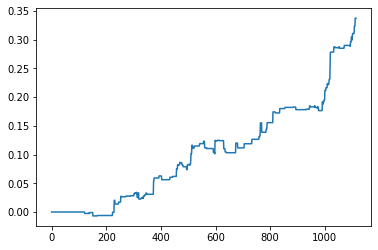

In [42]:
ret = newdata['ret'].cumsum()
plt.plot(ret.values)
plt.show()

推荐结果：
 - **采用日期长度117天，分钟长度103分钟，SD为0.077**的最优化结果。回测sharpe ratio结果为1.884429，calmar ratio为3.552027，年化收益率为7.8282%，最大回撤为2.2039%，策略胜率为62.9921%。